In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools as it

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
import warnings
np.warnings.filterwarnings('ignore')

In [50]:
# Loading test and train data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [51]:
train = train.drop(['Unnamed: 0'],axis=1)
test = test.drop(['Unnamed: 0'],axis=1)

In [52]:
# Separate into test and train
y_train = train.target
X_train = train.drop("target", axis = 1)

y_test = test.target
X_test = test.drop('target', axis = 1)

X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [53]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train_columns)

In [54]:
# Create a model object - not trained yet
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
# Use coef_ to return the coefficients - only log reg inference you can do with sklearn
print(logreg.coef_) 

[[-1.08118757e+00  1.08929963e-01  4.88798339e-01 -2.50027234e-01
   1.42340805e-01 -1.50062497e-01  5.58427565e-01  3.96802992e-01
   3.55824641e-01  1.73667311e-01  3.05392090e-01 -5.22995299e-01
  -3.62124152e-01  1.25913420e-01  1.53894906e-01 -4.45887034e-02
   2.87604505e-01 -3.39592174e-01 -2.71641218e-01 -1.08553818e-01
  -2.04737702e+00  1.24208102e-01  6.24605824e-02  4.27120871e-01
  -1.94921024e-01  3.90959261e-02 -2.51780239e-01  4.43498248e-01
   7.78110937e-02  3.11713362e-01  2.43759640e-01 -1.43542826e-01
  -1.04390746e-01  2.45761067e-01 -2.62347815e-02  2.26329740e-01
   1.23958245e-02 -4.16046333e-01  9.46671015e-02 -1.88455224e-02
   1.29591824e-03  1.48976817e-01  6.18653391e-02 -3.23987032e-01
   2.55334219e-01  1.48249426e-01  1.88828201e-01 -2.41778012e-01
   1.55425179e-01 -1.82218923e-02 -1.04288885e-01 -1.26653376e-01
  -2.28742108e-01 -1.90587680e-01 -1.91746291e-01 -9.78851298e-02
   2.57798534e-02  5.87336018e-02 -5.92511224e-02  8.01468364e-01
  -3.01955

In [56]:
# Get the predicted classes first
y_pred = logreg.predict(X_test)

# Use the predicted and true classes for accuracy
print(accuracy_score(y_pred, y_test)*100) 

86.14


In [57]:
# Use .score with test predictors and response to get the accuracy
# Implements the same thing under the hood
print(logreg.score(X_test, y_test)*100)  

86.14


In [58]:
#Computing the predicted probability for the observation to belong to the positive class (y=1);
#The 2nd column in the output of predict_proba() consists of the probability of the observation to 
#belong to the positive class (y=1)
y_pred_prob = logreg.predict_proba(X_test)[:,1] 

#Using the predicted probability computed above to find ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print(auc(fpr, tpr))# AUC of ROC

0.9129735600920138


Precision:  0.7782874617737003
Recall:  0.7163969035890219
Accuracy:  0.8614


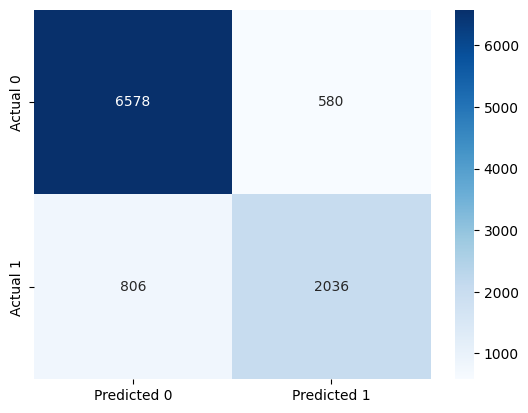

In [59]:
#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

In [60]:
# Finding cross-validation error for trees
param_grid = {    
    'C': 10**np.linspace(-10, 10),
}

cv = StratifiedKFold(n_splits=5)

grid_search_model = GridSearchCV(LogisticRegression(random_state = 1), param_grid = param_grid, 
                                       scoring = ['accuracy', 'recall'], refit = 'recall', n_jobs=-1, verbose=True,
                                       cv=cv)

grid_search_model.fit(X_train, y_train)

# make the predictions
y_pred = grid_search_model.predict(X_test)

print('Train accuracy : %.3f'%grid_search_model.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search_model.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search_model.best_score_)

print('Best params for recall')
print(grid_search_model.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Train accuracy : 0.910
Test accuracy : 0.865
Best accuracy Through Grid Search : 0.725
Best params for recall
{'C': 0.014563484775012445}


In [61]:
tree = LogisticRegression(random_state=1, C = 0.014563484775012445).fit(X_train, y_train)

cross_val_ypred = cross_val_predict(LogisticRegression(random_state=1, C = 0.014563484775012445), X_train, 
                                              y_train, cv = 5, method = 'predict_proba')

metrics = pd.DataFrame()
i = 0
threshold_hyperparam = np.arange(0, 1.01, 0.001)

for threshold in threshold_hyperparam:
  predicted = cross_val_ypred[:, 1] > threshold
  predicted = predicted.astype(int)

  accuracy = accuracy_score(predicted, y_train)*100
  metrics.loc[i, 'threshold'] = threshold
  metrics.loc[i, 'accuracy'] = accuracy
  metrics.loc[i, 'recall'] = recall_score(y_train, predicted)*100
  
  i = i + 1

In [62]:
metrics.loc[(metrics.accuracy>=85) & (metrics.recall>85), :].sort_values(by = 'recall', ascending = False).iloc[0,:]

threshold     0.193000
accuracy     85.000000
recall       87.818253
Name: 193, dtype: float64

In [63]:
metrics.loc[(metrics.accuracy>=85) & (metrics.recall>85), :].sort_values(by = 'accuracy', ascending = False).iloc[0,:]

threshold     0.245000
accuracy     86.050000
recall       85.076381
Name: 245, dtype: float64

In [69]:
metrics.iloc[range(225,235),:]

,threshold,accuracy,recall
225,0.225,85.80,86.251469
226,0.226,85.84,86.212299
227,0.227,85.86,86.212299
228,0.228,85.86,86.094790
229,0.229,85.87,85.938112
230,0.230,85.88,85.938112
231,0.231,85.89,85.859773
232,0.232,85.89,85.820603
233,0.233,85.91,85.820603
234,0.234,85.96,85.781434


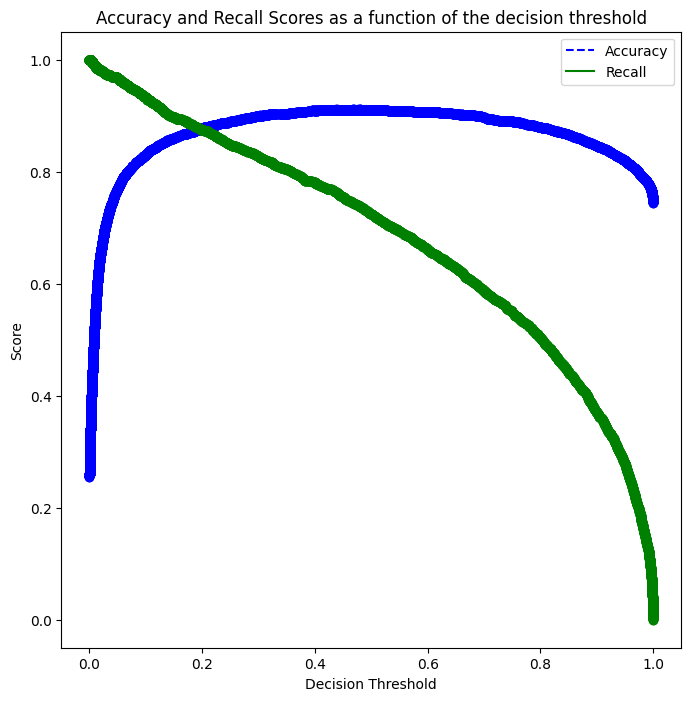

In [70]:
tree = LogisticRegression(random_state=1, C = 0.014563484775012445).fit(X_train, y_train)


tree.fit(X_train, y_train)

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []

for t in thresholds:
  y_pred_prob = tree.predict_proba(X_train)[:,1]
  y_pred = y_pred_prob > t
  y_pred = y_pred.astype(int)
  accuracy = (accuracy_score(y_pred, y_train))
  accuracy_list.append(accuracy)

def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
  plt.figure(figsize=(8,8))
  plt.title("Accuracy and Recall Scores as a function of the decision threshold")
  plt.plot(thresholds, accuracy_list, "b--", label = "Accuracy")
  plt.plot(thresholds, recalls[:-1], 'g-', label = "Recall")
  plt.plot(thresholds, accuracy_list, 'o', color = 'blue')
  plt.plot(thresholds, recalls[:-1], 'o', color = 'green')
  plt.ylabel('Score')
  plt.xlabel('Decision Threshold')
  plt.legend(loc='best')
  plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

Accuracy:  88.55
ROC-AUC:  0.964604605539677
Precision:  0.7137219186399514
Recall:  0.9208773991382687


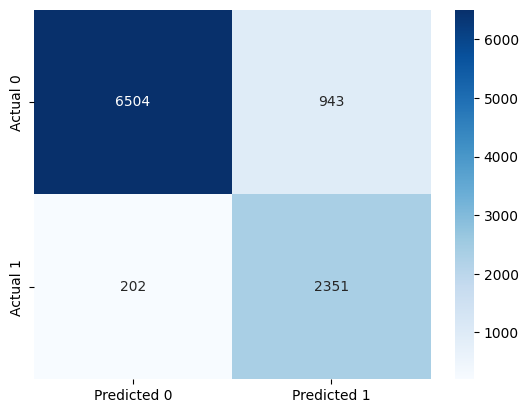

In [71]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.231

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  85.42999999999999
ROC-AUC:  0.9230603534300387
Precision:  0.6966770803748935
Recall:  0.8631245601688952


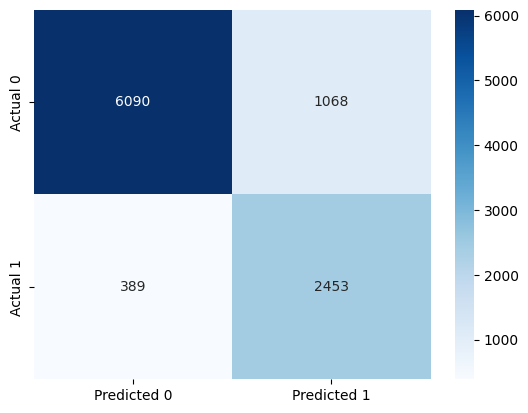

In [72]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.231

tree.fit(X_train, y_train)

y_pred_prob = tree.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');